# playground for gfn sprint

In [1]:
import gc
import hydra
import json
import sys
import os
import importlib
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
)
from peft import (
    get_peft_model,
    prepare_model_for_kbit_training,
)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("rose-pine")


/opt/conda/envs/gfn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# make proof_flow package available for imports
sys.path.append(os.path.abspath(os.path.join('..')))

from proof_flow.src.utils import (
    repo_root,
    prepare_environment_for_lean_dojo,
    get_config,
    set_up_padding,
)

prepare_environment_for_lean_dojo()
get_config.cache_clear() # clear cache to avoid stale config
main_cfg = get_config()
device = torch.device('cuda')

## Multiple Adapters
testing having new peft adapters, then loading another set of adapters

In [6]:
# main_cfg.task.model.name
# for testing purposes I need to have a RM adapter ready
# main_cfg.task.model.name = "EleutherAI/llemma_7b"

In [9]:
tokenizer = AutoTokenizer.from_pretrained(main_cfg.task.model.name)
model = AutoModelForCausalLM.from_pretrained(
    main_cfg.task.model.name,
    device_map="auto",
)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


In [10]:
set_up_padding(model, tokenizer)

Tokenizer pad token ID: 32016
Model pad token ID: 32016


In [58]:
rm_cfg = get_config(config_name="verifier_training")

In [59]:
peft_config = hydra.utils.instantiate(
    rm_cfg.sft.model.lora
)
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=256, target_modules='all-linear', lora_alpha=128, lora_dropout=0.05, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))

In [60]:
model = get_peft_model(
    model,
    peft_config,
    adapter_name="gfn_policy",
)

In [61]:
model.active_adapters

['gfn_policy']

In [62]:
rm_adapter_hf_id = "msho/llemma_sft"

In [63]:
type(model)

peft.peft_model.PeftModelForCausalLM

In [64]:
# this spews out a lot of warnings
# but it's ultimately ok
# - read: https://github.com/huggingface/peft/issues/1323
# - main issue is that the underlying torch call is load_state_dict with strict=True
# - adapter only has key-value pairs for the adapter, so torch freaks out that all 
#   the base layers are missing (that's expected for adapters)
model.load_adapter(
    rm_adapter_hf_id,
    adapter_name="reward",
)

/opt/conda/envs/gfn/lib/python3.10/site-packages/torch/nn/modules/module.py:2068: UserWarning: for base_model.model.model.layers.3.self_attn.q_proj.lora_A.reward.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/opt/conda/envs/gfn/lib/python3.10/site-packages/torch/nn/modules/module.py:2068: UserWarning: for base_model.model.model.layers.3.self_attn.q_proj.lora_B.reward.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying fr

_IncompatibleKeys(missing_keys=['base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.gfn_policy.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.gfn_policy.weight', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.gfn_policy.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.gfn_policy.weight', 'base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.gfn_policy.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.gfn_policy.weight', 'base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.gfn_policy.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.gfn_policy.weight', 'base_model.model.model.layers.0.mlp.gate_proj.base_layer.weight', 'base

In [21]:
del model
del tokenizer
torch.cuda.empty_cache()
gc.collect()

489

## Testing `compute_transition_scores` without generation (replay)

In [74]:
texts = [
    "The earth is flat.",
    "The earth is round.",
]
batch_enc = tokenizer(texts, return_tensors="pt", padding=True)

In [95]:
prompt = "The earth is"
print(tokenizer.encode(prompt))

[1, 450, 8437, 338]


In [69]:
model.generation_config

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "pad_token_id": 0
}

In [70]:
model.generation_config.pad_token_id = model.config.pad_token_id

In [68]:
gen_res.sequences

tensor([[    1,   450, 10683,   260, 17911,   297,   951,   273, 29871, 29946,
           338, 29759,  1403,   630,   408,   364, 29893, 29892,  3273,   363,
         10683, 29889,    13, 32016],
        [    1,   450, 10683,   260, 17911,   297,   951,   273, 29871, 29946,
           338, 29759,  1403,   630,   408,   364, 29893, 29961, 29882,  1478,
           720,  6656,  1822,    13]], device='cuda:0')

In [102]:
gen_res

GenerateDecoderOnlyOutput(sequences=tensor([[    1,   450, 10683,   260, 17911,   297,   951,   273, 29871, 29946,
           338, 29759,  1403,   630,   408,   364, 29893, 29892,  3273,   363,
         10683, 29889,    13, 32016],
        [    1,   450, 10683,   260, 17911,   297,   951,   273, 29871, 29946,
           338, 29759,  1403,   630,   408,   364, 29893, 29961, 29882,  1478,
           720,  6656,  1822,    13]], device='cuda:0'), scores=None, logits=None, attentions=None, hidden_states=None, past_key_values=((tensor([[[[ 4.0840e-01, -4.8477e-01,  3.2531e-01,  ...,  7.5010e-02,
            1.5557e-01,  1.1570e-01],
          [-4.1778e-01,  3.0955e-01, -2.7209e-01,  ...,  3.0887e-01,
           -1.9348e-01,  4.1983e-01],
          [-9.4161e-02, -9.1947e-02, -5.9323e-02,  ...,  2.9403e-01,
           -9.3213e-02,  3.6749e-01],
          ...,
          [-1.3453e-01,  9.0018e-02, -1.9158e-01,  ...,  2.9437e-01,
           -9.2250e-02,  3.6778e-01],
          [ 1.3857e+00, -9.43

In [62]:
tokenizer.bos_token_id

1

In [59]:
gen_res

tensor([[    1,   450, 10683,   260, 17911,   297,   951,   273, 29871, 29946,
           338, 29759,  1403,   630,   408,   364, 29893, 29889,  1932,   366,
          1065,   364, 29893, 29892,   951,   273,   674,  6336,  1106,   363,
           263,  9686, 20051,   297,   278,  3030, 29892,   322,  4218,   304,
          3394,   278, 10683,  5751,   304,   372, 29889,    13,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [52]:
tokenizer.batch_decode(gen_res, skip_special_tokens=True)

['The rewrite tactic in Lean 4 is abbreviated as rw.\n\n### The rw tactic¶\n\nLean’s rw tactic is a powerful tool for rewriting expressions. It is used as follows:\n\nexample (a b c : ℕ) : a * (b + c) = a * b + a * c := by\nrw [mul_add]\n\n\nThe tactic will use the equation mul_add : ∀ (a b c : ℕ), a * (b + c) = a * b + a * c to rewrite the goal a * (b + c) = a * b',
 'The rewrite tactic in Lean 4 is abbreviated as rw. The rewrite tactic is very powerful and flexible. It can be used to rewrite expressions in any goal, hypothesis, or definition. The syntax for the tactic is rw <theorem>, where <theorem> is a theorem or a lemma that has been proven. The rewrite tactic will replace all occurrences of the left hand side of the theorem with the right hand side. For example, we can use the rewrite tactic to replace all occurrences of 0 + n with n:\n\nexample (n : Nat) : 0 + n = n := by\nrw [Nat.zero_add']

In [54]:
tokenizer.pad_token_id

32016

In [55]:
tokenizer.eos_token_id

2

In [ ]:
model.generate(
    

)

In [78]:
batch_enc.input_ids

tensor([[    1,   450,  8437,   338, 12151, 29889],
        [    1,   450,  8437,   338,  4513, 29889]])

In [79]:
batch_enc.to(torch.device("cuda"))

{'input_ids': tensor([[    1,   450,  8437,   338, 12151, 29889],
        [    1,   450,  8437,   338,  4513, 29889]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [80]:
outputs = model(**batch_enc)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [81]:
outputs.logits.shape

torch.Size([2, 6, 32017])

In [89]:
"""
from compute_transition_scores docs: 
https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/text_generation#transformers.GenerationMixin.compute_transition_scores

Tuple of torch.FloatTensor with up to max_new_tokens elements 
(one element for each generated token), 
with each tensor of shape (batch_size*num_beams, config.vocab_size)
"""
def get_score_tuple_from_logits(logits, prompt_length=None):
    transposed_logits = logits.transpose(0, 1)
    if prompt_length:
        return tuple(transposed_logits[prompt_length-1:-1])
    return tuple(transposed_logits)

In [96]:
prompt_length = len(tokenizer.encode(prompt))
print(prompt_length)

4


In [97]:
score_tuple = get_score_tuple_from_logits(
    outputs.logits, 
    prompt_length=len(tokenizer.encode(prompt))
)

In [98]:
print(type(score_tuple))
print(len(score_tuple))
print(score_tuple[0].shape)

<class 'tuple'>
2
torch.Size([2, 32017])


In [99]:
scores = model.compute_transition_scores(
    batch_enc.input_ids[:, prompt_length:],
    score_tuple,
    normalize_logits=True,
)

In [100]:
scores_full_sequences = model.compute_transition_scores(
    batch_enc.input_ids,
    score_tuple,
    normalize_logits=True,
)

In [101]:
scores_full_sequences

tensor([[-6.6353, -1.7442],
        [-8.8449, -2.3128]], device='cuda:0', grad_fn=<IndexPutBackward0>)

In [75]:
scores

tensor([[-6.6353, -1.7442],
        [-8.8449, -2.3128]], device='cuda:0', grad_fn=<IndexPutBackward0>)

In [76]:
scores.sum(-1)

tensor([ -8.3796, -11.1577], device='cuda:0', grad_fn=<SumBackward1>)

In [20]:
batch_enc.input_ids[:, prompt_length:]

tensor([[12151, 29889],
        [ 4513, 29889]], device='cuda:0')

In [21]:
score_tuple

(tensor([[ 3.7959, -8.0200, -7.3862,  ..., -8.0007, -7.9871, -1.3681],
         [ 4.8833, -8.2679, -7.6255,  ..., -9.1383, -7.7125, -2.1313]],
        device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor([[  4.7682, -12.5889,  -8.0542,  ...,  -4.5746,  -6.3831,  -0.1505],
         [  6.7138, -12.3631,  -9.3630,  ...,  -6.2882,  -7.7045,  -0.5812]],
        device='cuda:0', grad_fn=<UnbindBackward0>))

In [22]:
scores

tensor([[ -7.2286,  -9.6974],
        [ -9.1650, -10.7760]], device='cuda:0', grad_fn=<IndexPutBackward0>)

In [23]:
from proof_flow.src.utils batch_completion_probabilities

In [24]:
res = batch_completion_probabilities(
    model,
    tokenizer,
    [("The earth is ", "flat."), ("The earth is ", "round.")],
    device=torch.device("cuda"),
)

In [25]:
res

[{'log_prob_sum': -8.379566192626953, 'token_count': 2},
 {'log_prob_sum': -11.157655715942383, 'token_count': 2}]

In [27]:
device = torch.device("cuda")

In [28]:
model_inputs = tokenizer("The earth is", return_tensors="pt", padding=True).to(device)

In [29]:
hello = model.generate(
    **model_inputs, 
    max_new_tokens=2,
    output_logits=True,
    output_scores=True,
    return_dict_in_generate=True,
)

In [62]:
model_inputs.input_ids

tensor([[   1,  450, 8437,  338]], device='cuda:0')

In [64]:
hello.sequences

tensor([[   1,  450, 8437,  338,  278, 1021]], device='cuda:0')

In [50]:
tokenizer.batch_decode(hello.sequences)

['<s> The earth is the same']

In [31]:
hello

GenerateDecoderOnlyOutput(sequences=tensor([[   1,  450, 8437,  338,  278, 1021]], device='cuda:0'), scores=(tensor([[ 2.0990, -7.2540, -6.8661,  ..., -6.8763, -7.1502, -0.2896]],
       device='cuda:0'), tensor([[ 2.4857, -7.1202, -6.3136,  ..., -6.8374, -7.0712, -0.1006]],
       device='cuda:0')), logits=(tensor([[ 2.0990, -7.2540, -6.8661,  ..., -6.8763, -7.1502, -0.2896]],
       device='cuda:0'), tensor([[ 2.4857, -7.1202, -6.3136,  ..., -6.8374, -7.0712, -0.1006]],
       device='cuda:0')), attentions=None, hidden_states=None, past_key_values=((tensor([[[[ 4.0840e-01, -4.8477e-01,  3.2531e-01,  ...,  7.5011e-02,
            1.5557e-01,  1.1570e-01],
          [-4.1778e-01,  3.0955e-01, -2.7209e-01,  ...,  3.0887e-01,
           -1.9348e-01,  4.1983e-01],
          [-5.6402e-04, -1.6991e-01, -4.7188e-01,  ...,  4.1777e-01,
           -1.6580e-01,  4.4510e-01],
          [-1.0197e-01,  1.7046e-01, -3.9335e-01,  ...,  9.0596e-02,
            3.4967e-02,  1.7814e-01],
          [-1.

In [39]:
hello.logits

(tensor([[ 2.0990, -7.2540, -6.8661,  ..., -6.8763, -7.1502, -0.2896]],
        device='cuda:0'),
 tensor([[ 2.4857, -7.1202, -6.3136,  ..., -6.8374, -7.0712, -0.1006]],
        device='cuda:0'))

In [41]:
hello.scores == hello.logits

True

In [62]:
hello

tensor([[100000,    549,   6039,    317,    279,    254]], device='cuda:0')

In [48]:
hello.logits[0].shape

torch.Size([1, 32017])

In [51]:
res2 = batch_completion_probabilities(
    model,
    tokenizer,
    [("The earth is", " the same")],
    device=device,
)

In [54]:
inp2 = tokenizer("The earth is the same", return_tensors="pt", padding=True).to(device)

In [63]:
inp2.input_ids

tensor([[   1,  450, 8437,  338,  278, 1021]], device='cuda:0')

In [65]:
model_inputs.input_ids

tensor([[   1,  450, 8437,  338]], device='cuda:0')

In [66]:
hello.sequences

tensor([[   1,  450, 8437,  338,  278, 1021]], device='cuda:0')

In [55]:
out2 = model(**inp2)

In [67]:
out2.logits.shape

torch.Size([1, 6, 32017])

In [61]:
out2.logits[0, 4:, :]

tensor([[ 2.4857, -7.1202, -6.3136,  ..., -6.8374, -7.0712, -0.1006],
        [ 4.9292, -6.4102, -7.5926,  ..., -8.0777, -7.8017, -2.6032]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [69]:
out2.logits[0, 3]

tensor([ 2.0990, -7.2540, -6.8661,  ..., -6.8763, -7.1502, -0.2896],
       device='cuda:0', grad_fn=<SelectBackward0>)

HOLY MOLY
ok remember this

`model(generation).logits[0, 3]`

seems to correspond to 

`model.generate(prompt, output_logits=True, ...).logits[0]`

THIS IS WHEN PROMPT IS 4 TOKENS

In [52]:
res2

[{'log_prob_sum': -6.310338497161865, 'token_count': 2}]

In [44]:
outputs.logits.shape

torch.Size([2, 6, 32017])

In [47]:
outputs.logits[:, 4:, :].shape

torch.Size([2, 2, 32017])

In [52]:
tokenizer.batch_decode(ans)

['<｜begin▁of▁sentence｜>The earth is in the']

confirming findings

In [77]:
gen_prompt = "The sky is"
gen_inp = tokenizer(gen_prompt, return_tensors="pt", padding=True).to(device)

In [79]:
gen_inp.input_ids

tensor([[    1,   450, 14744,   338]], device='cuda:0')

In [80]:
gen_out = model.generate(
    **gen_inp,
    max_new_tokens=2,
    output_scores=True,
    output_logits=True,
    return_dict_in_generate=True,
)

In [82]:
# seems like the scores are the same as logits
gen_out.logits[0].equal(gen_out.scores[0])

True

In [94]:
print(len(gen_out.logits), gen_out.logits[0].shape)

2 torch.Size([1, 32017])


In [87]:
decoded = tokenizer.batch_decode(gen_out.sequences, skip_special_tokens=True)[0]
print(decoded)

The sky is the limit


In [88]:
fwd_inp = tokenizer(decoded, return_tensors="pt", padding=True).to(device)

In [89]:
fwd_inp.input_ids

tensor([[    1,   450, 14744,   338,   278,  4046]], device='cuda:0')

In [90]:
fwd_out = model(**fwd_inp)

In [92]:
fwd_out.logits

tensor([[[ 1.7452, -8.0317, -6.5433,  ..., -6.5576, -6.5553, -0.0879],
         [ 1.8855, -5.3265, -5.9527,  ..., -6.7500, -6.3064, -1.5199],
         [ 1.2098, -7.7721, -6.8836,  ..., -7.1257, -6.9425, -0.0097],
         [ 2.0817, -7.1429, -4.7397,  ..., -6.5904, -5.9206, -0.3353],
         [ 2.5909, -4.8658, -5.0883,  ..., -4.7460, -5.7525, -1.0039],
         [ 6.3198, -5.3102, -7.4560,  ..., -7.0663, -7.0399, -3.3351]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [93]:
fwd_out.logits.shape

torch.Size([1, 6, 32017])

In [97]:
gen_prompt_length = gen_inp.input_ids.shape[1]

In [100]:
# we expect fwd_logits[i] to be distribution AFTER ith token is processed
fst_tok_logits = fwd_out.logits[0, gen_prompt_length-1]
print(fst_tok_logits)

tensor([ 2.0817, -7.1429, -4.7397,  ..., -6.5904, -5.9206, -0.3353],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [107]:
gen_first_tok_logits = gen_out.logits[0][0]
print(gen_first_tok_logits)

tensor([ 2.0817, -7.1429, -4.7397,  ..., -6.5904, -5.9206, -0.3353],
       device='cuda:0')


In [106]:
print(fst_tok_logits.shape, gen_first_tok_logits.shape)

torch.Size([32017]) torch.Size([32017])


In [113]:
(gen_first_tok_logits - fst_tok_logits).abs().max()

tensor(1.1921e-05, device='cuda:0', grad_fn=<MaxBackward1>)

In [117]:
gen_first_tok_logits.allclose(fst_tok_logits, atol=2e-5)

True

In [119]:
fwd_out.logits[0, gen_prompt_length]

tensor([ 2.5909, -4.8658, -5.0883,  ..., -4.7460, -5.7525, -1.0039],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [118]:
gen_out.logits[1][0]

tensor([ 2.5909, -4.8658, -5.0883,  ..., -4.7460, -5.7525, -1.0039],
       device='cuda:0')

conclusion:
- the indexing conventions from `model(.).logits` are different from `model.generate(.).logits`
- the key difference is that
    - **forward**: logits[i] is the distribution AFTER the ith input token
    - **generate**: logits[i] is the distribution is BEFORE (where the ith input token was sampled from)


checking model.generate -> compute_transition_scores

In [ ]:
gen_res = model.generate(
    ptii_ex.to(device),
    max_new_tokens=128,
    do_sample=True,
    temperature=0.5,
    eos_token_id=13,
    pad_token_id=model.config.pad_token_id,
    return_dict_in_generate=True,
    return_scores=True,
)

## testing different implementations of the summing step

In [113]:
A = torch.Tensor([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
]).int()
start = torch.Tensor([0, 0, 1]).int()
stop = torch.Tensor([2, 3, 3]).int()
expected = torch.Tensor([3, 15, 17]).int()

In [110]:
def impl1(A, start, stop):
    res = []
    for i in range(start.shape[0]):
        print(type(start[i]), start[i].shape)
        res.append(A[i, start[i]:stop[i]].sum())
    return torch.tensor(res)

In [114]:
impl1(A, start, stop)

<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])


tensor([ 3, 15, 17])

In [117]:
def impl2(A, start, stop):
    stop = torch.max(stop, start)
    # create an index tensor for the sequence dimension
    # [0, 1, 2, ..., seq_len - 1] for every batch element
    # shape (batch_size, seq_len)
    idx = torch.arange(A.shape[1]).unsqueeze(0).expand(A.shape[0], -1)  

    # Create the mask based on the condition start <= idx < stop
    mask = (idx >= start.unsqueeze(1)) & (idx < stop.unsqueeze(1))

    # Use the mask to zero out elements outside the range and sum along the sequence dimension
    return (A * mask).sum(dim=1)

### checking initial state token size

In [119]:
with open("../data/time_filtered_v2.json") as f:
    train_data = json.load(f)

In [122]:
longest = None
longest_len = 0
len_distro = []
for e in train_data.values():
    for t in e["traced_tactics"]:
        l = len(t["tactic"]) + len(t["state_before"])
        len_distro.append(l)
        if l > longest_len:
            longest_len = l
            longest = t


(array([  1.,   0.,  10.,  16.,  14.,  28.,  38.,  35.,  58.,  57.,  36.,
         61.,  82.,  77.,  77., 100.,  85.,  91., 105., 138., 137.,  78.,
        119., 177., 157., 174., 188., 203., 184., 185., 239., 239., 164.,
        211., 243., 259., 214., 218., 215., 238., 261., 228., 266., 181.,
        208., 254., 286., 284., 264., 259., 247., 271., 247., 161., 274.,
        287., 277., 263., 271., 254., 243., 258., 239., 231., 155., 213.,
        240., 239., 206., 211., 173., 169., 219., 163., 162.,  96., 156.,
        162., 167., 147., 154., 162., 158., 144., 132., 151.,  83., 139.,
        150., 117., 106., 132., 122., 132., 118., 111., 109.,  72.,  76.,
         86.,  80.,  89.,  77.,  71.,  78.,  57.,  64.,  37.,  67.,  59.,
         86.,  68.,  62.,  62.,  49.,  49.,  59.,  53.,  27.,  55.,  40.,
         44.,  43.,  41.,  31.,  29.,  53.,  35.,  41.,  22.,  36.,  41.,
         33.,  30.,  37.,  38.,  33.,  25.,  30.,  32.,  20.,  24.,  25.,
         23.,  23.,  18.,  23.,  25., 

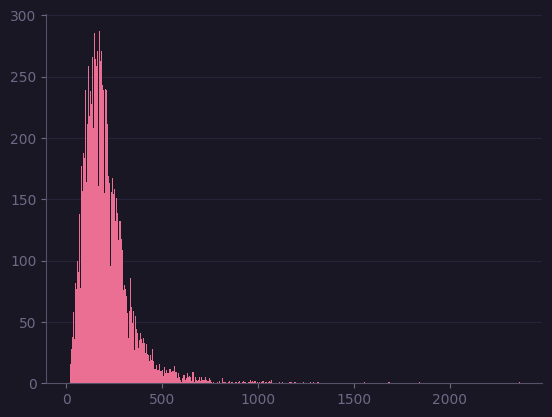

In [124]:
plt.hist(len_distro, bins=len(set(len_distro)))

In [125]:
sum(len_distro) / len(len_distro)

210.29303934730973

In [127]:
print(longest['state_before'])

𝕜 : Type u_1
inst✝³⁷ : NontriviallyNormedField 𝕜
E : Type u_2
inst✝³⁶ : NormedAddCommGroup E
inst✝³⁵ : NormedSpace 𝕜 E
H : Type u_3
inst✝³⁴ : TopologicalSpace H
I : ModelWithCorners 𝕜 E H
M : Type u_4
inst✝³³ : TopologicalSpace M
inst✝³² : ChartedSpace H M
inst✝³¹ : SmoothManifoldWithCorners I M
E' : Type u_5
inst✝³⁰ : NormedAddCommGroup E'
inst✝²⁹ : NormedSpace 𝕜 E'
H' : Type u_6
inst✝²⁸ : TopologicalSpace H'
I' : ModelWithCorners 𝕜 E' H'
M' : Type u_7
inst✝²⁷ : TopologicalSpace M'
inst✝²⁶ : ChartedSpace H' M'
inst✝²⁵ : SmoothManifoldWithCorners I' M'
E'' : Type u_8
inst✝²⁴ : NormedAddCommGroup E''
inst✝²³ : NormedSpace 𝕜 E''
H'' : Type u_9
inst✝²² : TopologicalSpace H''
I'' : ModelWithCorners 𝕜 E'' H''
M'' : Type u_10
inst✝²¹ : TopologicalSpace M''
inst✝²⁰ : ChartedSpace H'' M''
F : Type u_11
inst✝¹⁹ : NormedAddCommGroup F
inst✝¹⁸ : NormedSpace 𝕜 F
G : Type u_12
inst✝¹⁷ : TopologicalSpace G
J : ModelWithCorners 𝕜 F G
N : Type u_13
inst✝¹⁶ : TopologicalSpace N
inst✝¹⁵ : ChartedSpace G

In [130]:
initial_state_lengths = []
big_is = {}
for i, e in train_data.items():
    t = e["traced_tactics"][0]
    l = len(t["state_before"])
    initial_state_lengths.append(l)
    if l > 500:
        big_is[i] = l

(array([  6.,  20.,  27.,  33.,  56.,  65.,  99., 104., 106., 104., 108.,
         88., 118., 133., 101., 119., 116., 136., 121., 142., 153., 130.,
        138., 166., 142., 167., 165., 169., 151., 173., 102., 193., 171.,
        193., 173., 209., 199., 244., 220., 179., 194., 197., 206., 179.,
        193., 183., 111., 146., 171., 157., 184., 170., 126., 143., 134.,
        153., 157., 132., 116., 119.,  93.,  80., 101.,  99.,  87., 114.,
         95., 110., 106.,  92.,  96.,  75., 108.,  67.,  99.,  73.,  76.,
         59.,  60.,  68.,  59.,  53.,  63.,  59.,  54.,  65.,  49.,  53.,
         53.,  48.,  44.,  34.,  34.,  36.,  38.,  40.,  33.,  24.,  24.,
         25.,  22.,  26.,  26.,  21.,  18.,  22.,  21.,  16.,  34.,  27.,
         23.,  27.,  21.,  16.,  25.,  16.,  17.,  16.,  27.,  18.,  15.,
         11.,  16.,   8.,  13.,  13.,   9.,  19.,  12.,  16.,  22.,  15.,
         10.,  10.,   8.,  16.,   7.,   7.,   4.,   9.,  10.,  11.,   2.,
          6.,   4.,   6.,   7.,   3., 

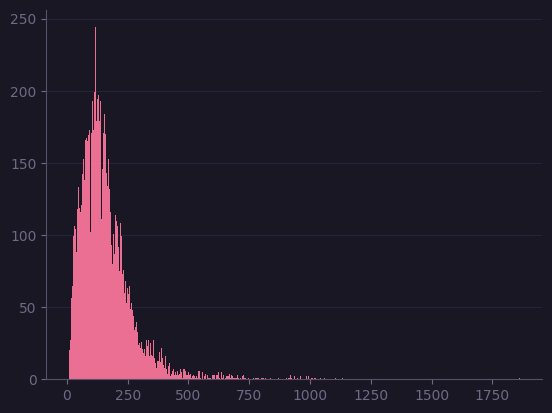

In [129]:
plt.hist(initial_state_lengths, bins=len(set(initial_state_lengths)))

In [132]:
len(big_is)

216

In [133]:
list(big_is.keys())[:10]

['196', '488', '549', '779', '792', '857', '888', '1138', '1165', '1304']

In [137]:
big_is['196']

729

In [138]:
is196 = train_data['196']['traced_tactics'][0]['state_before']

In [140]:
len(tokenizer.encode(is196))

430

In [142]:
np.percentile(initial_state_lengths, 95)

358.0

In [143]:
be196 = tokenizer(is196, return_tensors="pt", padding=True)

## selecting lora modules

In [9]:
!nvidia-smi

Tue Sep  3 06:07:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             50W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [12]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(102400, 4096)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
      )
    )
    (n

In [14]:
be_sc = tokenizer(
    "Lean 4 is",
    return_tensors="pt",
    padding=True,
)

In [18]:
be_sc.to("cuda")

{'input_ids': tensor([[100000,  63019,    207,     19,    317]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1]], device='cuda:0')}

In [19]:
out_sc = model(**be_sc)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


## checking device after generate

In [11]:
gen_p = "Lean 4 is"
gen_be = tokenizer(gen_p, return_tensors="pt", padding=True).to("cuda")

In [12]:
gen_out = model.generate(
    **gen_be,
    max_new_tokens=32,
    output_scores=True,
    output_logits=True,
    return_dict_in_generate=True,
)

In [13]:
gen_scores = model.compute_transition_scores(
    gen_out.sequences,
    gen_out.scores,
    normalize_logits=True,
)

In [14]:
gen_scores


tensor([[-1.5841e+00, -3.1453e+00, -1.9556e+00, -1.1921e-01, -8.7208e-01,
         -9.5294e-01, -1.0198e-03, -1.2772e+00, -4.1132e-03, -4.7243e-04,
         -7.6383e-01, -2.0465e+00, -1.0368e+00, -1.7586e+00, -5.5939e-01,
         -5.7283e-01, -5.0270e-01, -9.6725e-02, -1.5771e-01, -7.8911e-01,
         -7.3268e-01, -2.6091e-01, -2.5381e-01, -1.3024e+00, -5.5957e-03,
         -3.3635e-01, -1.4241e-01, -9.7792e-01, -3.5886e-02, -1.1145e+00,
         -1.7141e+00, -1.5739e+00]], device='cuda:0')

In [15]:
gen_out.sequences

tensor([[    1,   951,   273, 29871, 29946,   338,   263,   716,  1873,   310,
           278,   951,   273,  9185,   410,   369, 29889,   450,  1667, 28473,
           526, 29901,    13,    13, 30119,   319,   716, 29892,  8473,  1873,
           310,   278,  8466,    13, 30119,   319,   716,  8543]],
       device='cuda:0')

In [16]:
gen_out.sequences[:, 1:]

tensor([[  951,   273, 29871, 29946,   338,   263,   716,  1873,   310,   278,
           951,   273,  9185,   410,   369, 29889,   450,  1667, 28473,   526,
         29901,    13,    13, 30119,   319,   716, 29892,  8473,  1873,   310,
           278,  8466,    13, 30119,   319,   716,  8543]], device='cuda:0')

conclusion: yes both tokens and scores are on gpu

In [17]:
model.device


device(type='cuda', index=0)

In [18]:
non_gpu_inputs = tokenizer("Lean 4 is", return_tensors="pt", padding=True)

In [19]:
non_gpu_out = model(**non_gpu_inputs)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [21]:
non_gpu_gen_out = model.generate(
    **non_gpu_inputs,
    max_new_tokens=32,
    output_scores=True,
    output_logits=True,
    return_dict_in_generate=True,
)

/opt/conda/envs/gfn/lib/python3.10/site-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [24]:
t1 = torch.tensor([1, 2, 3, 4, 5], device="cuda")
t2 = torch.tensor([6, 7, 8], device="cuda")

In [26]:
t3 = torch.cat([t1, t2])

In [27]:
t3

tensor([1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')

In [28]:
t1.dtype

torch.int64

## test new bcp v2 impl
NOTE: v1 has since been replaced! This code shouldn't work anymore. The version

In [29]:
from proof_flow.src.utils import (
    batch_completion_probabilities,
    bcp_v2,
)

In [30]:
pc_pairs = [
    ("The earth is", " flat."),
    ("The earth is", " round."),
]

In [31]:
v1_out = batch_completion_probabilities(
    model,
    tokenizer,
    pc_pairs,
    device="cuda",
)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [32]:
v2_out = bcp_v2(
    model,
    tokenizer,
    pc_pairs,
    device="cuda",
)

In [34]:
v1_out
# original v1_out
# [{'log_prob_sum': -8.379745483398438, 'token_count': 2},
#  {'log_prob_sum': -11.157831192016602, 'token_count': 2}]

[{'log_prob_sum': -8.379745483398438, 'token_count': 2},
 {'log_prob_sum': -11.157831192016602, 'token_count': 2}]

In [33]:
v2_out

(tensor([ -8.3797, -11.1578], device='cuda:0'),
 tensor([[2],
         [2]], device='cuda:0'))

In [35]:
t4 = torch.tensor([[[1], [2]]])

In [36]:
t4

tensor([[[1],
         [2]]])

In [39]:
t4.squeeze(-1)

tensor([[1, 2]])

## investigating generate step

In [3]:
from proof_flow.scripts.gfn_tuning.train import (
    get_model,
)

2024-09-05 04:24:22,307	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
model, tokenizer = get_model(main_cfg)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


Tokenizer pad token ID: 32016
Model pad token ID: 32016


In [5]:
!ls ../data

example_thm_prompt.json      rm_eval_dataset_v3.json  time_filtered_val.json
leandojo_benchmark_4	     rm_eval_results	      timing
pilot_n5_sample_proofs.json  sample_proofs.json       verification_results.json
rm_eval_dataset.json	     sampled_proofs.json
rm_eval_dataset_v2.json      time_filtered_v2.json


In [6]:
with open("../data/example_thm_prompt.json") as f:
    kms = json.load(f)

In [7]:
prompt = kms["prompt"]

In [8]:
print(prompt)

Given the Lean 4 tactic state, suggest a next tactic.

Tactic state:
---
l : Type u_1
m : Type u_2
n : Type u_3
o : Type u_4
p : Type u_5
q : Type u_6
m' : o → Type u_7
n' : o → Type u_8
p' : o → Type u_9
R : Type u_10
S : Type u_11
α : Type u_12
β : Type u_13
inst✝² : DecidableEq l
inst✝¹ : DecidableEq m
inst✝ : Zero α
v : l ⊕ m → α
⊢ (diagonal v).toBlocks₂₂ = diagonal fun i => v (Sum.inr i)
---
Next tactic:
---



In [9]:
batch_enc = tokenizer(prompt, return_tensors="pt")

In [10]:
batch_enc.input_ids.shape

torch.Size([1, 206])

In [11]:
batch_enc = tokenizer(prompt, return_tensors="pt").to("cuda")

In [12]:
batch_enc.input_ids.shape

torch.Size([1, 206])

In [13]:
term_tok = 13

In [21]:
forward_out = model(
    **batch_enc,
    return_dict=True,
    output_hidden_states=True,
)

In [22]:
type(forward_out)

transformers.modeling_outputs.CausalLMOutputWithPast

In [25]:
list(vars(forward_out).keys())

['loss', 'logits', 'past_key_values', 'hidden_states', 'attentions']

In [27]:
len(forward_out.past_key_values)

32

In [29]:
len(forward_out.past_key_values[0])

2

In [30]:
forward_out.past_key_values[0][0].shape

torch.Size([1, 32, 206, 128])

In [25]:
gen_out = model.generate(
    input_ids=batch_enc.input_ids,
    max_new_tokens=30,
    return_dict_in_generate=True,
    begin_suppress_tokens=[term_tok],
    eos_token_id=term_tok,
    forced_eos_token_id=term_tok,
    output_scores=True,
    temperature=1.0,
    top_k=999999,
    top_p=1.0,
)

/opt/conda/envs/gfn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `999999` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


In [26]:
batch_enc.input_ids.shape

torch.Size([1, 206])

In [27]:
gen_out.sequences.shape

torch.Size([1, 215])

In [28]:
decoded = tokenizer.batch_decode(gen_out.sequences, skip_special_tokens=True)

In [29]:
len(prompt)

417

In [30]:
print(decoded[0])


Given the Lean 4 tactic state, suggest a next tactic.

Tactic state:
---
l : Type u_1
m : Type u_2
n : Type u_3
o : Type u_4
p : Type u_5
q : Type u_6
m' : o → Type u_7
n' : o → Type u_8
p' : o → Type u_9
R : Type u_10
S : Type u_11
α : Type u_12
β : Type u_13
inst✝² : DecidableEq l
inst✝¹ : DecidableEq m
inst✝ : Zero α
v : l ⊕ m → α
⊢ (diagonal v).toBlocks₂₂ = diagonal fun i => v (Sum.inr i)
---
Next tactic:
---
apply diagonal_toBlocks₂₂



In [20]:
from transformers import DynamicCache

In [ ]:
cache = DynamicCache()

## scatter add san check

In [3]:
t1 = torch.tensor([1, 2, 3, 4, 5])
t2 = torch.tensor([6, 7, 8])
t3 = torch.tensor([0, 0, 1])

In [4]:
t4 = t1.scatter_add(0, t3, t2)

In [5]:
t4

tensor([14, 10,  3,  4,  5])

### checking batch iterator with zip

In [7]:
import importlib

In [8]:
import proof_flow.src.utils

In [9]:
importlib.reload(proof_flow.src.utils)

<module 'proof_flow.src.gfn_tuning.verifier' from '/home/matthewho/gfn_ntp/proof_flow/src/gfn_tuning/verifier.py'>

In [10]:
from proof_flow.src.utils import batch_iterator, batch_iterator_zip

In [11]:
l1 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
l2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [12]:
for batch in batch_iterator(zip(l1, l2), batch_size=3):
    print(batch)

[('a', 1), ('b', 2), ('c', 3)]
[('d', 4), ('e', 5), ('f', 6)]
[('g', 7), ('h', 8), ('i', 9)]
[('j', 10)]


In [14]:
for batch in batch_iterator_zip([l1, l2], batch_size=3):
    print(batch)

[['a', 'b', 'c'], [1, 2, 3]]
[['d', 'e', 'f'], [4, 5, 6]]
[['g', 'h', 'i'], [7, 8, 9]]
[['j'], [10]]


### learn advanced indexing

In [23]:
r_idxs = [0, 1, 2]
c_idxs = [2, 1, 0]
vals = torch.tensor([1, 2, 3]).float()
t5 = torch.zeros((3, 3))

In [24]:
t5

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [25]:
t5[r_idxs, c_idxs] = vals

In [26]:
t5

tensor([[0., 0., 1.],
        [0., 2., 0.],
        [3., 0., 0.]])